# Jupyter notebook for debugging

In [1]:
%load_ext autoreload
%autoreload 2

# Copied from `train` function in train_simple.py:L78
import yaml

device = 'cpu'
hyp = 'data/hyps/hyp.scratch-low.yaml'

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

In [2]:
from models.yolo import Model
from utils.general import check_dataset

cfg = 'models/yolov5n_kaist-rgbt.yaml'
data = 'data/kaist-rgbt.yaml'
data_dict = check_dataset(data)

nc = int(data_dict["nc"])  # number of classes
model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

Overriding model.yaml nc=1 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.MultiStreamConv           [3, 16, 6, 2, 2]              
  1                -1  1      9344  models.common.MultiStreamConv           [16, 32, 3, 2]                
  2                -1  1      9600  models.common.MultiStreamC3             [32, 32, 1]                   
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1      4224  models.common.Conv                      [64, 64, 1, 1]                
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 2]                
  6                -1  2     29184  models.common.C3                        [64, 64, 2]                   
  7                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               

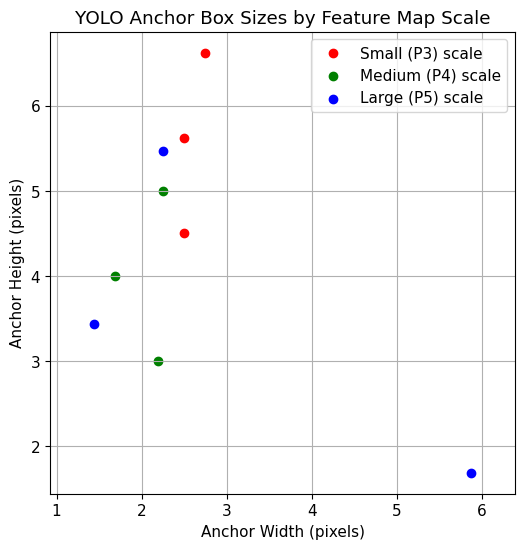

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# anchor 값: tensor of shape [3, num_anchors_per_scale, 2] (width, height)
anchors = model.model[-1].anchors  # typically [3, 6, 2]

# 시각화용 플롯
plt.figure(figsize=(6, 6))
colors = ['red', 'green', 'blue']
scale_names = ['Small (P3)', 'Medium (P4)', 'Large (P5)']

for i, scale_anchors in enumerate(anchors):
    anchor_wh = scale_anchors.cpu().detach().numpy()
    widths, heights = anchor_wh[:, 0], anchor_wh[:, 1]
    plt.scatter(widths, heights, c=colors[i], label=f'{scale_names[i]} scale')

# 축 정보 및 범례
plt.xlabel('Anchor Width (pixels)')
plt.ylabel('Anchor Height (pixels)')
plt.title('YOLO Anchor Box Sizes by Feature Map Scale')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()

Parsed 13312 GT boxes from XML


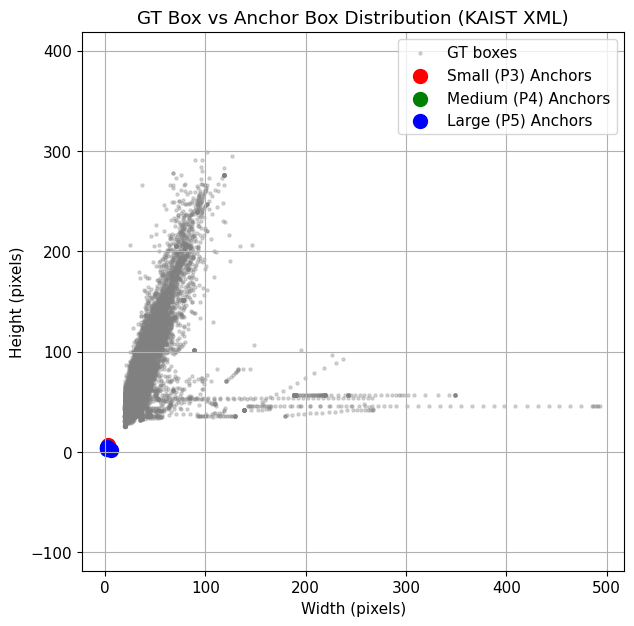

In [4]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np

label_xml_folder = r'D:\AUE8088\datasets\kaist-rgbt\train\labels-xml'
gt_wh = []

for file in os.listdir(label_xml_folder):
    if not file.endswith('.xml'):
        continue
    path = os.path.join(label_xml_folder, file)
    try:
        tree = ET.parse(path)
        root = tree.getroot()
        objects = root.findall('object')
        if not objects:
            continue

        for obj in objects:
            bndbox = obj.find('bndbox')
            if bndbox is None:
                continue
            try:
                w = float(bndbox.find('w').text)
                h = float(bndbox.find('h').text)
                if w > 0 and h > 0:
                    gt_wh.append([w, h])
            except Exception as e:
                print(f"[Warning] {file}: {e}")
                continue
    except Exception as e:
        print(f"[Error] Parsing {file} failed: {e}")
        continue

gt_wh = np.array(gt_wh)
print(f"Parsed {len(gt_wh)} GT boxes from XML")

# Anchor 시각화
anchors = model.model[-1].anchors
colors = ['red', 'green', 'blue']
scale_names = ['Small (P3)', 'Medium (P4)', 'Large (P5)']

plt.figure(figsize=(7, 7))
plt.scatter(gt_wh[:, 0], gt_wh[:, 1], s=5, alpha=0.3, c='gray', label='GT boxes')

for i, scale_anchors in enumerate(anchors):
    wh = scale_anchors.cpu().detach().numpy()
    plt.scatter(wh[:, 0], wh[:, 1], c=colors[i], s=100, label=f'{scale_names[i]} Anchors')

plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.title('GT Box vs Anchor Box Distribution (KAIST XML)')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()


In [5]:
import numpy as np
import random

def iou(box, clusters):
    """Calculate the IoU between a box and k clusters (width, height)"""
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]
    iou_ = intersection / (box_area + cluster_area - intersection + 1e-10)
    return iou_

def kmeans(boxes, k=9, dist=np.median, seed=42):
    """k-means clustering with IoU as distance metric"""
    np.random.seed(seed)
    clusters = boxes[np.random.choice(len(boxes), k, replace=False)]
    prev_clusters = np.zeros(clusters.shape)
    iter = 0
    while True:
        distances = np.array([1 - iou(box, clusters) for box in boxes])
        nearest_clusters = np.argmin(distances, axis=1)
        for cluster in range(k):
            if np.any(nearest_clusters == cluster):
                clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)
        if np.all(clusters == prev_clusters):
            break
        prev_clusters = clusters.copy()
        iter += 1
    return clusters

# 실행
anchors = kmeans(np.array(gt_wh), k=9)
anchors = anchors[np.argsort(anchors[:, 0])].reshape(3, 3, 2)

# 출력
print("📌 New Anchors (W, H):")
for i, scale in enumerate(anchors):
    print(f"Scale {i+1}: {scale.round(1).tolist()}")

# YOLO 형식 출력
anchors_flat = anchors.reshape(3, -1).round().astype(int).tolist()
print("\n📎 YOLO anchor format:")
print(anchors_flat)



📌 New Anchors (W, H):
Scale 1: [[20.0, 36.0], [20.0, 45.0], [22.0, 53.0]]
Scale 2: [[27.0, 64.0], [35.0, 48.0], [36.0, 80.0]]
Scale 3: [[46.0, 110.0], [72.0, 175.0], [188.0, 54.0]]

📎 YOLO anchor format:
[[20, 36, 20, 45, 22, 53], [27, 64, 35, 48, 36, 80], [46, 110, 72, 175, 188, 54]]


## Sanity check: dataset
- Read images and label
- Visualize bounding boxes

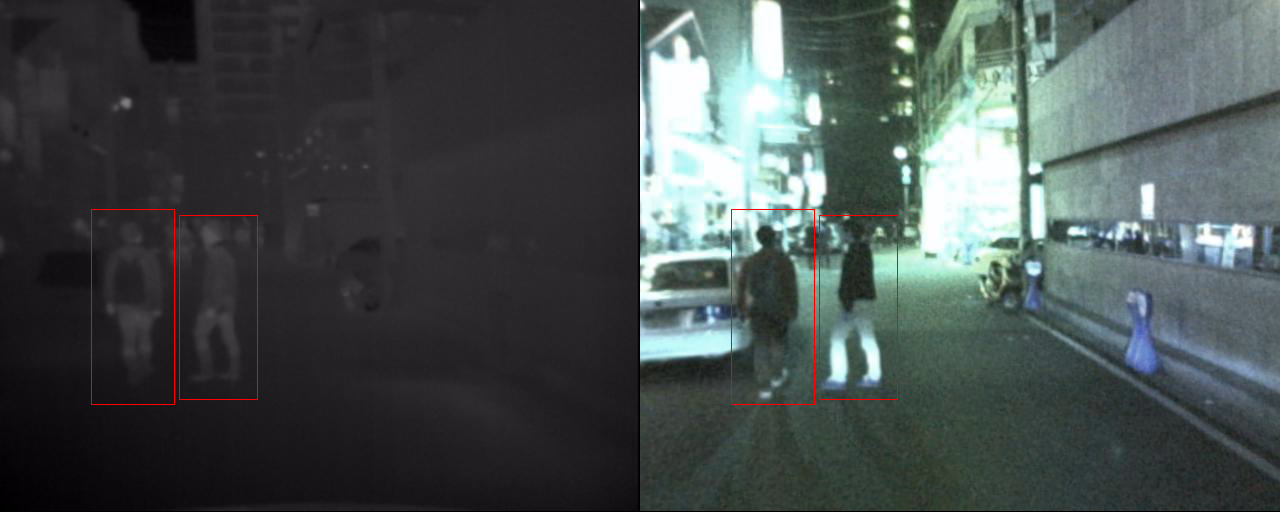

In [6]:
import cv2
import os
import numpy as np
from PIL import Image

annFile = 'datasets/kaist-rgbt/train/labels/set05_V000_I01219.txt'
lwirFile = annFile.replace('labels', 'images/lwir').replace('.txt', '.jpg')
visFile  = annFile.replace('labels', 'images/visible').replace('.txt', '.jpg')

# Read images
img_lwir = cv2.imread(lwirFile)
img_vis  = cv2.imread(visFile)

h, w = img_vis.shape[:2]

# Read labels
with open(annFile, 'r') as fp:
    labels = [x.split() for x in fp.read().strip().splitlines() if len(x)]

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    # convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = np.zeros((len(labels), 4))
    xyxy[:, :2] = labels[:, 1:3]
    xyxy[:, 2:] = labels[:, 1:3] + labels[:, 3:5]
    xyxy = xyxy.astype(np.int16)

    for c, bb in zip(cls, xyxy):
        color = colors[c]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis,  bb[:2], bb[2:], color)

images = np.concatenate([img_lwir, img_vis], axis=1)
Image.fromarray(images)

## Sanity check: dataset class
- Visualize bounding boxes from dataset class

In [7]:
from utils.dataloaders import create_dataloader
from utils.general import check_img_size, colorstr

imgsz = 640
batch_size = 1
single_cls = False
seed = 0

train_path = data_dict["train"]
gs = max(int(model.stride.max()), 32)  # grid size (max stride)
imgsz = check_img_size(imgsz, gs, floor=gs * 2)  # verify imgsz is gs-multiple

train_loader, dataset = create_dataloader(
    train_path,
    imgsz,
    batch_size,
    gs,
    single_cls,
    hyp=hyp,
    augment=False,      # TODO: check if there is no bug when applying augmentation
    cache=None,
    rect=False,
    rank=-1,
    workers=8,
    image_weights=False,
    quad=False,
    prefix=colorstr("train: "),
    shuffle=False,      # No shuffle for debugging
    seed=seed,
    rgbt_input=True,
)


train: Scanning D:\AUE8088\datasets\kaist-rgbt\train-all-04.cache... 12538 images, 7009 backgrounds, 0 corrupt: 100%|██████████| 12538/12538 [00:00<?, ?it/s]


datasets\kaist-rgbt\train\images\{}\set05_V000_I01219.jpg


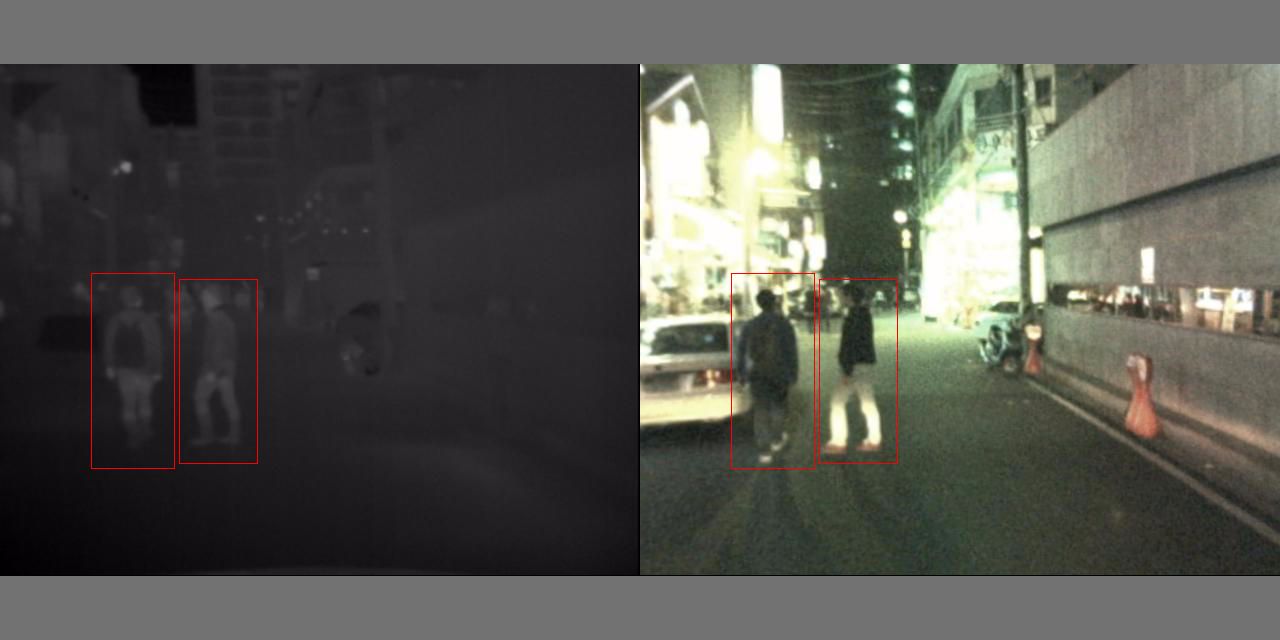

In [8]:
from utils.dataloaders import LoadRGBTImagesAndLabels
from utils.general import xywh2xyxy

frame = 12112

# Get a minibatch
# for ii, (imgs, targets, paths, _) in enumerate(train_loader):
#     break

# Get a minibatch (fast)
imgs, targets, paths, shapes, _ = LoadRGBTImagesAndLabels.collate_fn([dataset[frame]])

idx = 0
img_lwir = imgs[0][idx].numpy().transpose((1, 2, 0))
img_vis  = imgs[1][idx].numpy().transpose((1, 2, 0))
h, w = img_vis.shape[:2]

labels = targets.numpy()

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    labels = labels[labels[:, 0] == idx, 1:]

    # convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = xywh2xyxy(labels[:, 1:5])
    xyxy = xyxy.astype(np.int16)

    img_lwir = np.ascontiguousarray(img_lwir)
    img_vis = np.ascontiguousarray(img_vis)

    for c, bb in zip(cls, xyxy):
        color = colors[c]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis,  bb[:2], bb[2:], color)

images = np.concatenate([img_lwir, img_vis], axis=1)
print(paths[idx])
Image.fromarray(images)

## Run trained model
- Visualize bounding boxes from dataset class

In [9]:
import torch
from models.yolo import Model
from utils.torch_utils import select_device

weights = 'kaist-rgbt_best.pt'      # Train your own model!
data = 'data/kaist-rgbt.yaml'
cfg = 'models/yolov5s_kaist-rgbt.yaml'
hyp = 'data/hyps/hyp.scratch-low.yaml'
nc = 1
half = False  # use FP16 half-precision inference
dnn = False  # use OpenCV DNN for ONNX inference
device = select_device('cpu')

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

# inference
model.eval()
ims = [im.to(device, non_blocking=True).float() / 255 for im in imgs]    # For RGB-T input
with torch.no_grad():
    pred = model(ims)  # forward

YOLOv5  v7.0-338-gbddaf3c8 Python-3.11.9 torch-2.7.0+cpu CPU


                 from  n    params  module                                  arguments                     
  0                -1  1      7040  models.common.MultiStreamConv           [3, 32, 6, 2, 2]              
  1                -1  1     37120  models.common.MultiStreamConv           [32, 64, 3, 2]                
  2                -1  1     37632  models.common.MultiStreamC3             [64, 64, 1]                   
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1     16640  models.common.Conv                      [128, 128, 1, 1]              
  5                -1  1    147712  models.common.Conv                      [128, 128, 3, 2]              
  6                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  7                -1  1    295424  models.common.Conv                      [128,

In [22]:
import torch
import cv2
import numpy as np
import yaml
from matplotlib import pyplot as plt

from models.yolo import Model
from utils.torch_utils import select_device
from utils.general import scale_boxes, non_max_suppression

# ----------------------------
# 1. 경로 설정
# ----------------------------
vis_path = r'D:/AUE8088/datasets/kaist-rgbt/test/images/visible/set00_V007_I00279.jpg'
lwir_path = r'D:/AUE8088/datasets/kaist-rgbt/test/images/lwir/set00_V007_I00279.jpg'
cfg = 'models/yolov5s_kaist-rgbt.yaml'
weights = 'kaist-rgbt_best.pt'
hyp_path = 'data/hyps/hyp.scratch-low.yaml'
device = select_device('cpu')
nc = 4  # person, cyclist, people, person?

# ----------------------------
# 2. 하이퍼파라미터 및 모델 로드
# ----------------------------
with open(hyp_path, errors="ignore") as f:
    hyp = yaml.safe_load(f)

model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)
ckpt = torch.load(weights, map_location=device)
model.load_state_dict(ckpt['model'].state_dict(), strict=False)
model.eval()

# ----------------------------
# 3. 전처리 함수 정의
# ----------------------------
def preprocess(img):
    img = cv2.resize(img, (640, 640))
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, HWC → CHW
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).float() / 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    return img

# ----------------------------
# 4. 이미지 불러오기 및 전처리
# ----------------------------
img_vis = cv2.imread(vis_path)      # 원본 이미지 (BGR)
img_lwir = cv2.imread(lwir_path)    # 열화상 이미지 (BGR or Gray)

img_vis_tensor = preprocess(img_vis)
img_lwir_tensor = preprocess(img_lwir)

img_input = [img_vis_tensor.to(device), img_lwir_tensor.to(device)]  # 멀티 스트림 입력

# ----------------------------
# 5. 추론 및 NMS
# ----------------------------
with torch.no_grad():
    pred = model(img_input)[0]

# NMS
conf_thres = 0.1  # 낮춰서 최대한 많은 객체 확인
iou_thres = 0.45
pred = non_max_suppression(pred, conf_thres, iou_thres, classes=None, agnostic=False, max_det=1000)

# ----------------------------
# 6. 시각화
# ----------------------------
img_show = img_vis.copy()  # 시각화용 복사본

for i, det in enumerate(pred):
    if len(det):
        det[:, :4] = scale_boxes(img_vis_tensor.shape[2:], det[:, :4], img_show.shape).round()
        for *xyxy, conf, cls in det:
            label = f'{int(cls.item())} {conf:.2f}'  # 모델.names 없을 수 있음
            xyxy = [int(x.item()) for x in xyxy]
            cv2.rectangle(img_show, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (255, 0, 0), 2)
            cv2.putText(img_show, label, (xyxy[0], xyxy[1] - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 1)

# ----------------------------
# 7. 결과 출력
# ----------------------------
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.title("YOLOv5 KAIST-RGBT Detection")
plt.axis("off")
plt.show()


YOLOv5  v7.0-338-gbddaf3c8 Python-3.11.9 torch-2.7.0+cpu CPU

Overriding model.yaml nc=1 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      7040  models.common.MultiStreamConv           [3, 32, 6, 2, 2]              
  1                -1  1     37120  models.common.MultiStreamConv           [32, 64, 3, 2]                
  2                -1  1     37632  models.common.MultiStreamC3             [64, 64, 1]                   
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1     16640  models.common.Conv                      [128, 128, 1, 1]              
  5                -1  1    147712  models.common.Conv                      [128, 128, 3, 2]              
  6                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  7                -1  1    295424  models.c

FileNotFoundError: [Errno 2] No such file or directory: 'kaist-rgbt_best.pt'

In [ ]:
pred[0]

tensor([], size=(0, 6))